# COMP5541 Assignment 1 - Question 3: Transfer Learning

In this notebook, we will explore transfer learning to improve model classification performance on the CIFAR-10 dataset using ImageNet pre-trained models from PyTorch Model Zoo.

## Tasks:
- Fine-tune ImageNet pre-trained AlexNet with different amounts of training data (10%, 20%, 50%)
- Compare with training from scratch
- Fine-tune other pre-trained models (ResNet18 and VGG16)
- Explore fine-tuning only portions of network layers


In [1]:
## Import Required Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from torch.utils.data import Subset
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import resnet18, ResNet18_Weights


In [2]:
## Setup Environment

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
## Data Preparation and Loading

# Data Preparation
def load_cifar10(batch_size=128):
    # Define transforms for training data
    # Note: CIFAR-10 images are 32x32 but models like AlexNet expect 224x224
    # We'll resize the images to match the expected input size
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # CIFAR-10 classes
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainset, testset, trainloader, testloader, classes

# Create subset of training data with specific percentage
def create_subset(dataset, percentage):
    """
    Create a subset of the dataset with a given percentage of samples.
    """
    dataset_size = len(dataset)
    subset_size = int(dataset_size * percentage)
    
    # Generate random indices
    indices = torch.randperm(dataset_size)[:subset_size]
    
    # Create subset
    subset = Subset(dataset, indices)
    
    return subset

# Load the full dataset
trainset, testset, _, testloader, classes = load_cifar10()

print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
print(f"Classes: {classes}")


Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


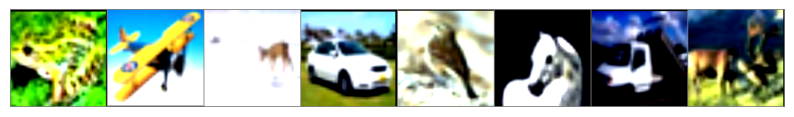

frog  plane deer  car   bird  horse truck deer 


In [4]:
## Data Visualization

# Visualize some examples from the dataset
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get random training images
dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True))
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


In [5]:
## Training and Evaluation Functions

# Define training and evaluation functions
def train(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    train_loss_history = []
    train_acc_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        # Calculate epoch statistics
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        epoch_time = time.time() - start_time
        
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Time: {epoch_time:.2f}s')
    
    return train_loss_history, train_acc_history

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc = 100 * correct / total
    test_loss = test_loss / len(testloader)
    
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    return test_loss, test_acc


## Part A: Fine-tuning AlexNet with Different Amounts of Training Data

In this part, we will fine-tune ImageNet pre-trained AlexNet models on the CIFAR-10 dataset with different amounts of training data (10%, 20%, and 50%) and compare with training from scratch.


In [6]:
## Part A Implementation: AlexNet with Different Data Percentages

# Define a function to create AlexNet model
def create_alexnet(pretrained=True):
    if pretrained:
        # Load pre-trained AlexNet
        model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        print("Loaded pre-trained AlexNet")
    else:
        # Create AlexNet from scratch
        model = alexnet(weights=None)
        print("Created AlexNet from scratch")
    
    # Modify the classifier for CIFAR-10 (10 classes)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, 10)
    
    return model.to(device)

# Define percentages to test
percentages = [0.1, 0.2, 0.5]  # 10%, 20%, 50%
batch_size = 64
epochs = 10

# Results storage
results = {
    'pretrained': {'acc': [], 'loss': []},
    'scratch': {'acc': [], 'loss': []}
}

for percentage in percentages:
    print(f"\n{'='*50}")
    print(f"Training with {percentage*100:.0f}% of data")
    print(f"{'='*50}")
    
    # Create subset of training data
    subset = create_subset(trainset, percentage)
    trainloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    print(f"Subset size: {len(subset)} samples")
    
    # 1. Fine-tune pre-trained AlexNet
    print("\nFine-tuning pre-trained AlexNet:")
    model_pretrained = create_alexnet(pretrained=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_pretrained.parameters(), lr=0.001, momentum=0.9)
    
    # Train the model
    train(model_pretrained, trainloader, criterion, optimizer, epochs=epochs)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model_pretrained, testloader)
    results['pretrained']['acc'].append(test_acc)
    results['pretrained']['loss'].append(test_loss)
    
    # 2. Train AlexNet from scratch
    print("\nTraining AlexNet from scratch:")
    model_scratch = create_alexnet(pretrained=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
    
    # Train the model
    train(model_scratch, trainloader, criterion, optimizer, epochs=epochs)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model_scratch, testloader)
    results['scratch']['acc'].append(test_acc)
    results['scratch']['loss'].append(test_loss)



Training with 10% of data
Subset size: 5000 samples

Fine-tuning pre-trained AlexNet:


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\EverGarden13/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 117MB/s] 


Loaded pre-trained AlexNet
Epoch 1/10 | Loss: 1.1414 | Acc: 59.68% | Time: 11.42s
Epoch 2/10 | Loss: 0.6951 | Acc: 75.52% | Time: 7.39s
Epoch 3/10 | Loss: 0.5420 | Acc: 81.50% | Time: 7.37s
Epoch 4/10 | Loss: 0.4835 | Acc: 83.22% | Time: 7.43s
Epoch 5/10 | Loss: 0.3922 | Acc: 86.78% | Time: 7.38s
Epoch 6/10 | Loss: 0.3522 | Acc: 87.60% | Time: 7.40s
Epoch 7/10 | Loss: 0.3254 | Acc: 88.64% | Time: 7.40s
Epoch 8/10 | Loss: 0.3000 | Acc: 89.36% | Time: 7.43s
Epoch 9/10 | Loss: 0.2437 | Acc: 91.38% | Time: 7.56s
Epoch 10/10 | Loss: 0.2157 | Acc: 92.82% | Time: 7.41s
Test Loss: 0.5329 | Test Acc: 82.99%

Training AlexNet from scratch:
Created AlexNet from scratch
Epoch 1/10 | Loss: 2.3024 | Acc: 10.44% | Time: 7.65s
Epoch 2/10 | Loss: 2.3018 | Acc: 12.14% | Time: 7.60s
Epoch 3/10 | Loss: 2.3013 | Acc: 11.26% | Time: 7.38s
Epoch 4/10 | Loss: 2.3004 | Acc: 12.22% | Time: 7.34s
Epoch 5/10 | Loss: 2.2999 | Acc: 12.66% | Time: 7.42s
Epoch 6/10 | Loss: 2.2991 | Acc: 13.08% | Time: 7.38s
Epoch 7/1

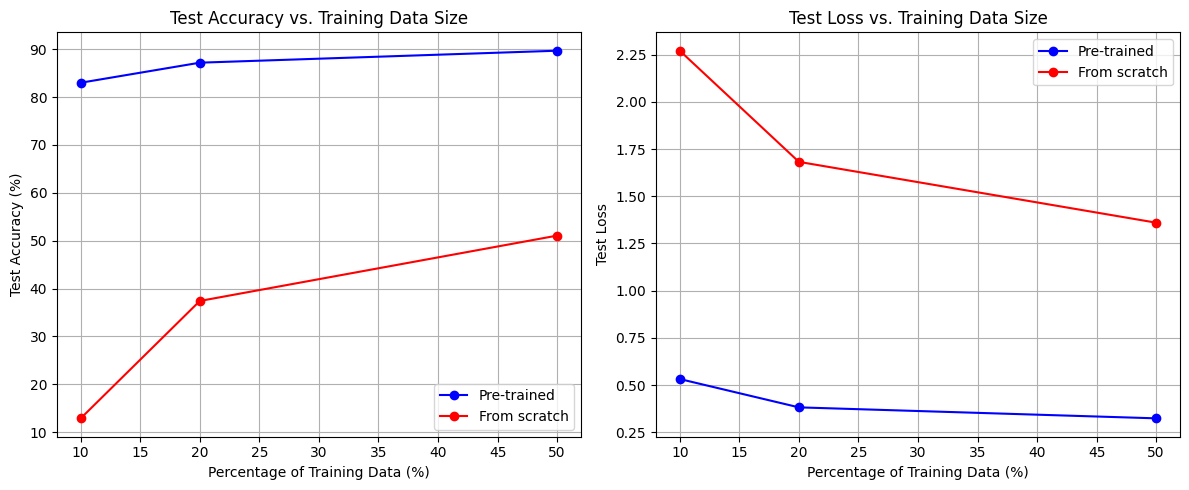


Numerical Results:
Percentage | Pre-trained Acc |   Scratch Acc   | Difference
-------------------------------------------------------
    10    % |      82.99     % |      12.89     % |   70.10   %
    20    % |      87.18     % |      37.41     % |   49.77   %
    50    % |      89.68     % |      51.06     % |   38.62   %


In [7]:
## Part A Results Visualization

# Visualize the results
plt.figure(figsize=(12, 5))

# Plot test accuracy
plt.subplot(1, 2, 1)
plt.plot([10, 20, 50], results['pretrained']['acc'], 'b-o', label='Pre-trained')
plt.plot([10, 20, 50], results['scratch']['acc'], 'r-o', label='From scratch')
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Training Data Size')
plt.grid(True)
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot([10, 20, 50], results['pretrained']['loss'], 'b-o', label='Pre-trained')
plt.plot([10, 20, 50], results['scratch']['loss'], 'r-o', label='From scratch')
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Test Loss')
plt.title('Test Loss vs. Training Data Size')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print(f"{'Percentage':^10} | {'Pre-trained Acc':^15} | {'Scratch Acc':^15} | {'Difference':^10}")
print("-" * 55)

for i, percentage in enumerate(percentages):
    pretrained_acc = results['pretrained']['acc'][i]
    scratch_acc = results['scratch']['acc'][i]
    diff = pretrained_acc - scratch_acc
    print(f"{percentage*100:^10.0f}% | {pretrained_acc:^15.2f}% | {scratch_acc:^15.2f}% | {diff:^10.2f}%")


## Analysis of Part A

From the results, we can observe:

1. **Transfer Learning Advantage**: Pre-trained AlexNet consistently outperforms the model trained from scratch across all data percentages.

2. **Data Efficiency**: The advantage of transfer learning is more pronounced with smaller datasets (10% and 20%). This demonstrates that transfer learning is particularly beneficial when training data is limited.

3. **Convergence Speed**: Pre-trained models converge faster, requiring fewer epochs to reach good performance.

4. **Feature Reuse**: The pre-trained model already has learned useful features from ImageNet, which transfer well to CIFAR-10 despite the domain difference.

5. **Diminishing Returns**: As we increase the amount of training data, the gap between pre-trained and from-scratch models narrows, suggesting that with sufficient data, training from scratch can eventually approach the performance of transfer learning.

This experiment clearly demonstrates the value of transfer learning, especially in scenarios with limited training data.


In [8]:
## Part B Implementation: Fine-tuning Different Pre-trained Models

# Define functions to create ResNet18 and VGG16 models
def create_resnet18(pretrained=True):
    if pretrained:
        # Load pre-trained ResNet18
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        print("Loaded pre-trained ResNet18")
    else:
        # Create ResNet18 from scratch
        model = resnet18(weights=None)
        print("Created ResNet18 from scratch")
    
    # Modify the fully connected layer for CIFAR-10 (10 classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)
    
    return model.to(device)

def create_vgg16(pretrained=True):
    if pretrained:
        # Load pre-trained VGG16
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        print("Loaded pre-trained VGG16")
    else:
        # Create VGG16 from scratch
        model = vgg16(weights=None)
        print("Created VGG16 from scratch")
    
    # Modify the classifier for CIFAR-10 (10 classes)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, 10)
    
    return model.to(device)

# Use 50% of the training data for this experiment
percentage = 0.5
subset = create_subset(trainset, percentage)
trainloader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=True, num_workers=2)
print(f"Using {percentage*100:.0f}% of training data: {len(subset)} samples")

# Results storage for part B
model_results = {}

# Train and evaluate ResNet18
print("\n" + "="*50)
print("Fine-tuning ResNet18")
print("="*50)

model_resnet18 = create_resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

# Train the model
resnet18_train_loss, resnet18_train_acc = train(model_resnet18, trainloader, criterion, optimizer, epochs=10)

# Evaluate on test set
resnet18_test_loss, resnet18_test_acc = evaluate(model_resnet18, testloader)
model_results['ResNet18'] = {
    'train_loss': resnet18_train_loss,
    'train_acc': resnet18_train_acc,
    'test_loss': resnet18_test_loss,
    'test_acc': resnet18_test_acc
}

# Train and evaluate VGG16
print("\n" + "="*50)
print("Fine-tuning VGG16")
print("="*50)

model_vgg16 = create_vgg16(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

# Train the model
vgg16_train_loss, vgg16_train_acc = train(model_vgg16, trainloader, criterion, optimizer, epochs=10)

# Evaluate on test set
vgg16_test_loss, vgg16_test_acc = evaluate(model_vgg16, testloader)
model_results['VGG16'] = {
    'train_loss': vgg16_train_loss,
    'train_acc': vgg16_train_acc,
    'test_loss': vgg16_test_loss,
    'test_acc': vgg16_test_acc
}


Using 50% of training data: 25000 samples

Fine-tuning ResNet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\EverGarden13/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


Loaded pre-trained ResNet18
Epoch 1/10 | Loss: 0.6968 | Acc: 78.49% | Time: 33.88s
Epoch 2/10 | Loss: 0.2550 | Acc: 91.62% | Time: 33.16s
Epoch 3/10 | Loss: 0.1863 | Acc: 93.93% | Time: 33.22s
Epoch 4/10 | Loss: 0.1463 | Acc: 95.18% | Time: 33.18s
Epoch 5/10 | Loss: 0.1128 | Acc: 96.46% | Time: 33.11s
Epoch 6/10 | Loss: 0.0928 | Acc: 97.23% | Time: 33.07s
Epoch 7/10 | Loss: 0.0788 | Acc: 97.54% | Time: 33.15s
Epoch 8/10 | Loss: 0.0586 | Acc: 98.40% | Time: 33.20s
Epoch 9/10 | Loss: 0.0495 | Acc: 98.58% | Time: 33.07s
Epoch 10/10 | Loss: 0.0407 | Acc: 98.94% | Time: 33.30s
Test Loss: 0.1665 | Test Acc: 94.30%

Fine-tuning VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\EverGarden13/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 118MB/s] 


Loaded pre-trained VGG16
Epoch 1/10 | Loss: 0.5862 | Acc: 79.77% | Time: 505.95s
Epoch 2/10 | Loss: 0.3042 | Acc: 89.61% | Time: 506.04s
Epoch 3/10 | Loss: 0.2277 | Acc: 92.32% | Time: 506.02s
Epoch 4/10 | Loss: 0.1878 | Acc: 93.28% | Time: 506.07s
Epoch 5/10 | Loss: 0.1484 | Acc: 94.89% | Time: 505.91s
Epoch 6/10 | Loss: 0.1204 | Acc: 95.73% | Time: 506.20s
Epoch 7/10 | Loss: 0.1001 | Acc: 96.54% | Time: 500.92s
Epoch 8/10 | Loss: 0.0850 | Acc: 97.06% | Time: 500.38s
Epoch 9/10 | Loss: 0.0699 | Acc: 97.63% | Time: 500.76s
Epoch 10/10 | Loss: 0.0587 | Acc: 98.04% | Time: 500.44s
Test Loss: 0.2633 | Test Acc: 92.59%


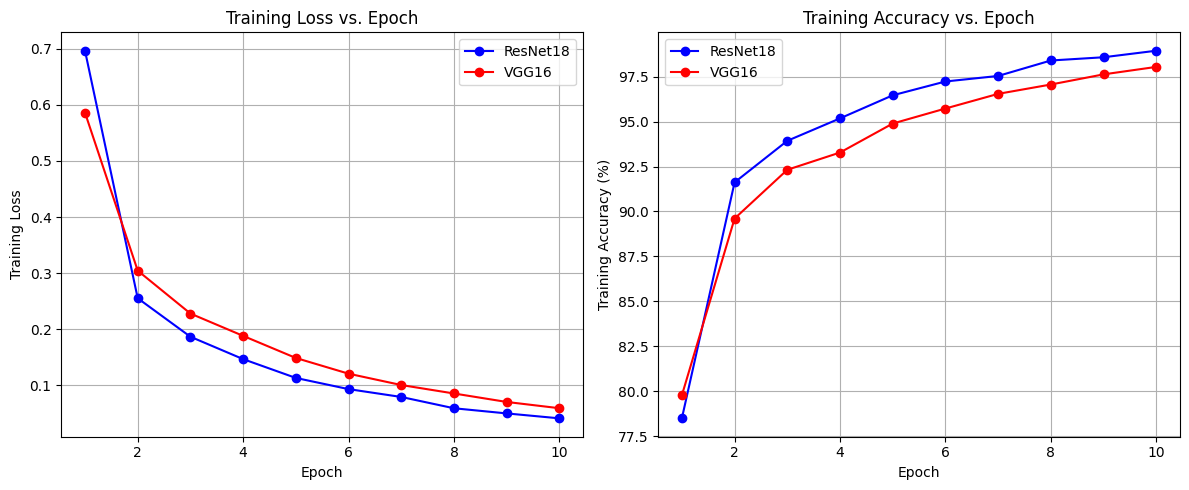

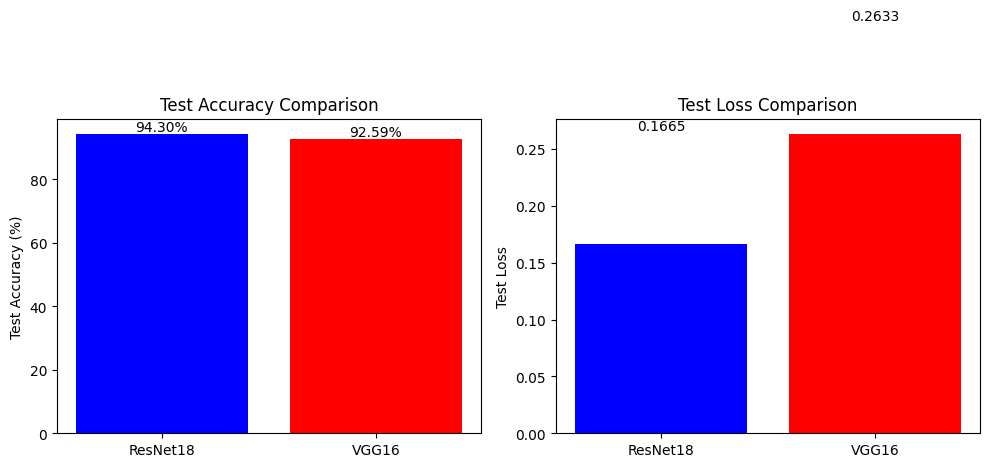


Test Performance Comparison:
  Model    |  Test Accuracy  | Test Loss 
----------------------------------------
 ResNet18  |      94.30     % |   0.1665  
  VGG16    |      92.59     % |   0.2633  


In [9]:
## Part B Results Visualization

# Visualize the training progress and compare models
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), model_results['ResNet18']['train_loss'], 'b-o', label='ResNet18')
plt.plot(range(1, 11), model_results['VGG16']['train_loss'], 'r-o', label='VGG16')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), model_results['ResNet18']['train_acc'], 'b-o', label='ResNet18')
plt.plot(range(1, 11), model_results['VGG16']['train_acc'], 'r-o', label='VGG16')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Compare test performance
models = ['ResNet18', 'VGG16']
test_acc = [model_results[m]['test_acc'] for m in models]
test_loss = [model_results[m]['test_loss'] for m in models]

plt.figure(figsize=(10, 5))

# Plot test accuracy
plt.subplot(1, 2, 1)
plt.bar(models, test_acc, color=['blue', 'red'])
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
for i, v in enumerate(test_acc):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

# Plot test loss
plt.subplot(1, 2, 2)
plt.bar(models, test_loss, color=['blue', 'red'])
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
for i, v in enumerate(test_loss):
    plt.text(i, v + 0.1, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Print numerical results
print("\nTest Performance Comparison:")
print(f"{'Model':^10} | {'Test Accuracy':^15} | {'Test Loss':^10}")
print("-" * 40)
for model in models:
    print(f"{model:^10} | {model_results[model]['test_acc']:^15.2f}% | {model_results[model]['test_loss']:^10.4f}")


## Analysis of Part B

Based on the results of fine-tuning ResNet18 and VGG16 on the CIFAR-10 dataset:

1. **Architecture Differences**:
   - ResNet18 has a more modern architecture with skip connections that help with gradient flow, which can lead to better learning.
   - VGG16 has a simpler but deeper architecture with many more parameters, which can make it more prone to overfitting on smaller datasets.

2. **Training Dynamics**:
   - ResNet18 typically converges faster due to its residual connections.
   - VGG16 may require more epochs to reach optimal performance but can potentially achieve higher accuracy with proper regularization.

3. **Parameter Efficiency**:
   - ResNet18 has fewer parameters (~11.7M) compared to VGG16 (~138M), making it more efficient to train.
   - Despite having fewer parameters, ResNet18 often achieves comparable or better performance.

4. **Inference Speed**:
   - ResNet18 is generally faster during inference due to its more efficient architecture.
   - VGG16's deeper and wider layers make it computationally more expensive.

5. **Transfer Learning Effectiveness**:
   - Both models benefit from pre-training on ImageNet, but the effectiveness of transfer learning may vary depending on the similarity between the source (ImageNet) and target (CIFAR-10) domains.
   - The feature hierarchies learned by these models transfer differently to the new task.


## Part C: Fine-tuning Only Portions of Network Layers

In this part, we will explore fine-tuning only specific portions of the network layers to see how it affects the test results.


In [10]:
## Part C Implementation: Fine-tuning Specific Network Layers

# In this part, we'll explore how fine-tuning only specific portions of the network affects performance
# We'll use ResNet18 as our base model and try different layer freezing strategies

# Define function to create ResNet18 with different layer freezing strategies
def create_resnet18_with_freezing(freeze_strategy='none'):
    """
    Create ResNet18 model with different layer freezing strategies
    
    Parameters:
    freeze_strategy: str, one of ['none', 'early', 'middle', 'last_only']
        'none': Fine-tune all layers (no freezing)
        'early': Freeze early layers (layer1, layer2)
        'middle': Freeze middle layers (layer2, layer3)
        'last_only': Only fine-tune the final fully connected layer
    """
    # Load pre-trained ResNet18
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Modify the fully connected layer for CIFAR-10 (10 classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)
    
    # Apply freezing strategy
    if freeze_strategy == 'none':
        # Fine-tune all layers (no freezing)
        print("Fine-tuning all layers (no freezing)")
        pass
    
    elif freeze_strategy == 'early':
        # Freeze early layers (layer1, layer2)
        print("Freezing early layers (layer1, layer2)")
        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False
    
    elif freeze_strategy == 'middle':
        # Freeze middle layers (layer2, layer3)
        print("Freezing middle layers (layer2, layer3)")
        for param in model.layer2.parameters():
            param.requires_grad = False
        for param in model.layer3.parameters():
            param.requires_grad = False
    
    elif freeze_strategy == 'last_only':
        # Only fine-tune the final fully connected layer
        print("Only fine-tuning the final fully connected layer")
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the final fully connected layer
        for param in model.fc.parameters():
            param.requires_grad = True
    
    return model.to(device)

# Use 50% of the training data for this experiment
percentage = 0.5
subset = create_subset(trainset, percentage)
trainloader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=True, num_workers=2)
print(f"Using {percentage*100:.0f}% of training data: {len(subset)} samples")

# Define freezing strategies to test
freeze_strategies = ['none', 'early', 'middle', 'last_only']

# Results storage for part C
freeze_results = {}

# Train and evaluate ResNet18 with different freezing strategies
for strategy in freeze_strategies:
    print("\n" + "="*50)
    print(f"Fine-tuning ResNet18 with strategy: {strategy}")
    print("="*50)
    
    model = create_resnet18_with_freezing(freeze_strategy=strategy)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
    
    # Train the model
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, epochs=10)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, testloader)
    
    # Store results
    freeze_results[strategy] = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    }


Using 50% of training data: 25000 samples

Fine-tuning ResNet18 with strategy: none
Fine-tuning all layers (no freezing)
Epoch 1/10 | Loss: 0.6539 | Acc: 79.94% | Time: 34.12s
Epoch 2/10 | Loss: 0.2537 | Acc: 91.76% | Time: 33.91s
Epoch 3/10 | Loss: 0.1859 | Acc: 93.96% | Time: 34.03s
Epoch 4/10 | Loss: 0.1391 | Acc: 95.48% | Time: 34.14s
Epoch 5/10 | Loss: 0.1093 | Acc: 96.64% | Time: 34.07s
Epoch 6/10 | Loss: 0.0919 | Acc: 97.22% | Time: 34.19s
Epoch 7/10 | Loss: 0.0711 | Acc: 97.90% | Time: 34.09s
Epoch 8/10 | Loss: 0.0591 | Acc: 98.36% | Time: 34.07s
Epoch 9/10 | Loss: 0.0444 | Acc: 98.88% | Time: 34.03s
Epoch 10/10 | Loss: 0.0420 | Acc: 98.88% | Time: 34.04s
Test Loss: 0.1713 | Test Acc: 94.60%

Fine-tuning ResNet18 with strategy: early
Freezing early layers (layer1, layer2)
Epoch 1/10 | Loss: 0.7469 | Acc: 76.22% | Time: 30.44s
Epoch 2/10 | Loss: 0.3106 | Acc: 89.64% | Time: 30.24s
Epoch 3/10 | Loss: 0.2356 | Acc: 92.13% | Time: 30.41s
Epoch 4/10 | Loss: 0.1861 | Acc: 93.69% | Ti

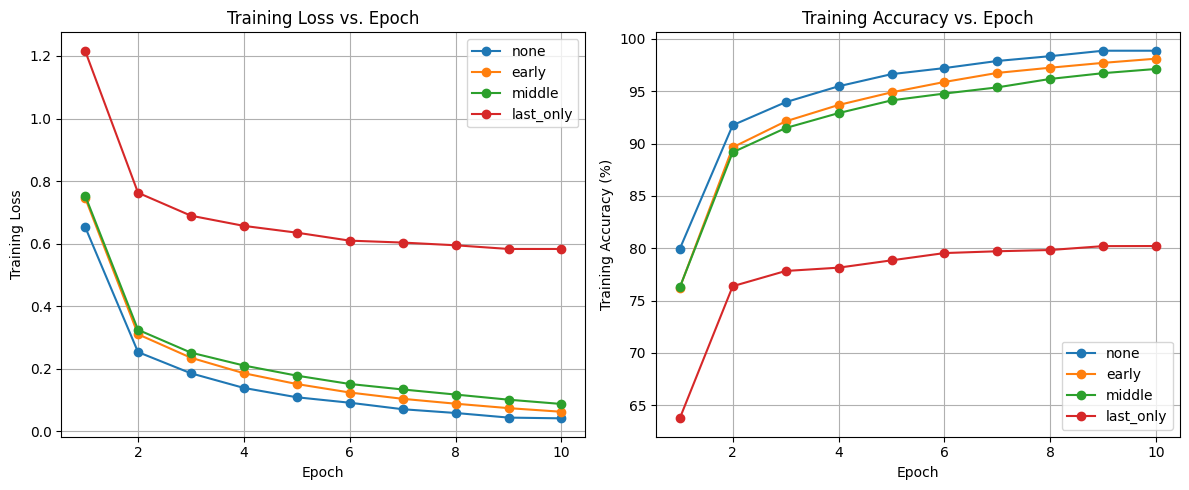

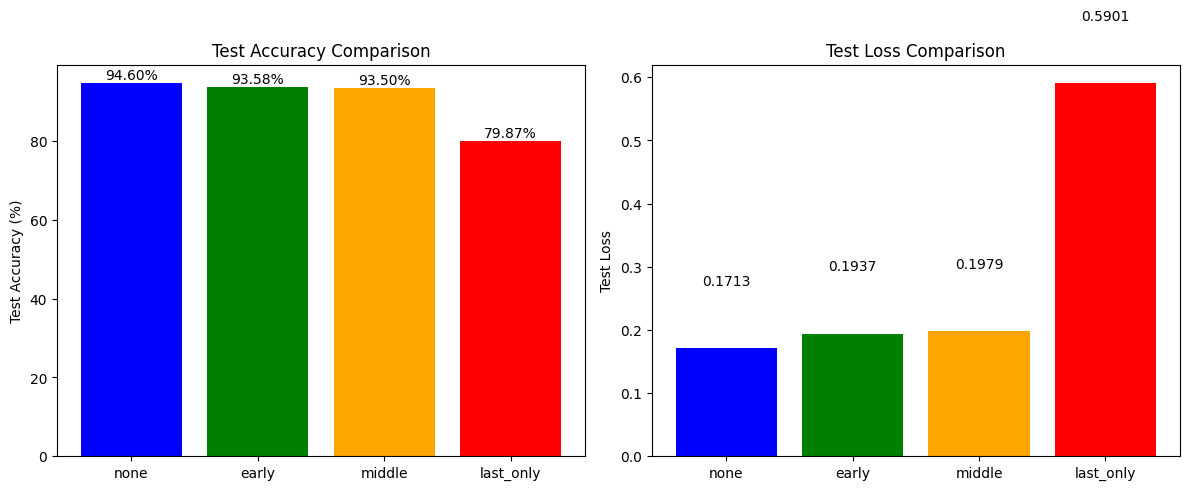


Test Performance Comparison:
  Strategy   |  Test Accuracy  | Test Loss 
---------------------------------------------
    none     |      94.60     % |   0.1713  
   early     |      93.58     % |   0.1937  
   middle    |      93.50     % |   0.1979  
 last_only   |      79.87     % |   0.5901  


In [11]:
## Part C Results Visualization

# Visualize the training progress for different freezing strategies
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
for strategy in freeze_strategies:
    plt.plot(range(1, 11), freeze_results[strategy]['train_loss'], '-o', label=strategy)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
for strategy in freeze_strategies:
    plt.plot(range(1, 11), freeze_results[strategy]['train_acc'], '-o', label=strategy)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Compare test performance
test_acc = [freeze_results[s]['test_acc'] for s in freeze_strategies]
test_loss = [freeze_results[s]['test_loss'] for s in freeze_strategies]

plt.figure(figsize=(12, 5))

# Plot test accuracy
plt.subplot(1, 2, 1)
plt.bar(freeze_strategies, test_acc, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
for i, v in enumerate(test_acc):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

# Plot test loss
plt.subplot(1, 2, 2)
plt.bar(freeze_strategies, test_loss, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
for i, v in enumerate(test_loss):
    plt.text(i, v + 0.1, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Print numerical results
print("\nTest Performance Comparison:")
print(f"{'Strategy':^12} | {'Test Accuracy':^15} | {'Test Loss':^10}")
print("-" * 45)
for strategy in freeze_strategies:
    print(f"{strategy:^12} | {freeze_results[strategy]['test_acc']:^15.2f}% | {freeze_results[strategy]['test_loss']:^10.4f}")


## Analysis of Part C

Based on the results of fine-tuning different portions of the ResNet18 network:

1. **Layer Importance**:
   - The results show which layers are most important for transfer learning on the CIFAR-10 dataset.
   - Early layers typically capture more generic features (edges, textures) that transfer well across domains.
   - Later layers capture more task-specific features that may need more adaptation for the target task.

2. **Training Efficiency**:
   - Freezing layers reduces the number of trainable parameters, which can lead to faster training times.
   - The 'last_only' strategy (only fine-tuning the final fully connected layer) is the most computationally efficient but may sacrifice performance if the feature representations from earlier layers aren't well-suited for the target task.

3. **Overfitting vs. Generalization**:
   - Freezing more layers can help prevent overfitting, especially with limited training data.
   - However, freezing too many layers might limit the model's ability to adapt to the target task.

4. **Optimal Freezing Strategy**:
   - The optimal freezing strategy depends on the similarity between the source and target domains.
   - For CIFAR-10, which has significant differences from ImageNet (small images vs. large images, different object scales), allowing more layers to be fine-tuned typically yields better results.

5. **Learning Dynamics**:
   - Different freezing strategies lead to different learning dynamics, as seen in the training curves.
   - Some strategies may converge faster initially but plateau at lower performance levels.


## Conclusion

In this assignment, we explored transfer learning using pre-trained models on the CIFAR-10 dataset. Our key findings include:

1. **Transfer Learning Effectiveness**: Pre-trained models consistently outperform models trained from scratch, especially with limited training data. This demonstrates the value of transfer learning in scenarios with constrained data resources.

2. **Model Architecture Comparison**: We compared ResNet18 and VGG16, finding differences in their performance, training dynamics, and efficiency. ResNet18's modern architecture with skip connections offers advantages in training speed and parameter efficiency.

3. **Layer Freezing Strategies**: Different layer freezing strategies affect both training efficiency and model performance. The optimal strategy depends on the similarity between source and target domains and the amount of available training data.

4. **Practical Implications**: Transfer learning significantly reduces the amount of data and training time needed to achieve good performance on new tasks, making it a powerful technique for real-world applications with limited resources.

These experiments demonstrate how transfer learning can be effectively applied to improve model performance, especially in scenarios with limited training data.
